In [ ]:
!pip install shap
!pip install pandas==1.2.0
!pip install --upgrade xlrd
!pip install --upgrade pandas
!pip install nfl_data_py
!pip install imbalanced-learn
!pip install nflfastpy
!pip install numpy
!pip install nfl_data_py

## Install and Import Necessary Packages

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import plotly.graph_objects as go
import nfl_data_py as nfl
#import nflfastpy as nfl

# ML models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/BetAIData/NFL

/content/drive/MyDrive/BetAIData/NFL


## Organize Data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# get file names to upload
dir_idx: str = "/content/drive/MyDrive/BetAIData/2000.xls"
df = pd.read_excel(dir_idx)
features: list = ['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Round', 'Best of', 
                  'Winner', "Loser", 'Surface', 'WRank', 'LRank', "Wsets", 'Lsets', "Comment"]              
df = df[features]

for i in tqdm(range(2001, 2023)): 
  if i < 2013: 
    dir_idx: str = f"/content/drive/MyDrive/BetAIData/{i}.xls"
  else: 
    dir_idx: str = f"/content/drive/MyDrive/BetAIData/{i}.xlsx"
  
  df_add = pd.read_excel(dir_idx)
  df_add = df_add[features]
  df = pd.concat([df, df_add])

FileNotFoundError: ignored

In [ ]:
df = df[df['Comment'] == 'Completed']

## Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61296 entries, 0 to 2631
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         61296 non-null  int64         
 1   Location    61296 non-null  object        
 2   Tournament  61296 non-null  object        
 3   Date        61296 non-null  datetime64[ns]
 4   Series      61296 non-null  object        
 5   Court       61296 non-null  object        
 6   Round       61296 non-null  object        
 7   Best of     61281 non-null  float64       
 8   Winner      61296 non-null  object        
 9   Loser       61296 non-null  object        
 10  Surface     61296 non-null  object        
 11  WRank       61276 non-null  object        
 12  LRank       61191 non-null  object        
 13  Wsets       61008 non-null  float64       
 14  Lsets       61006 non-null  float64       
 15  Comment     61296 non-null  object        
dtypes: datetime64[ns](1), f

In [ ]:
df['Best of'].value_counts()

3.0    49642
5.0    11639
Name: Best of, dtype: int64

<ipython-input-56-dc239bdebb06>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_tbl = df.corr()


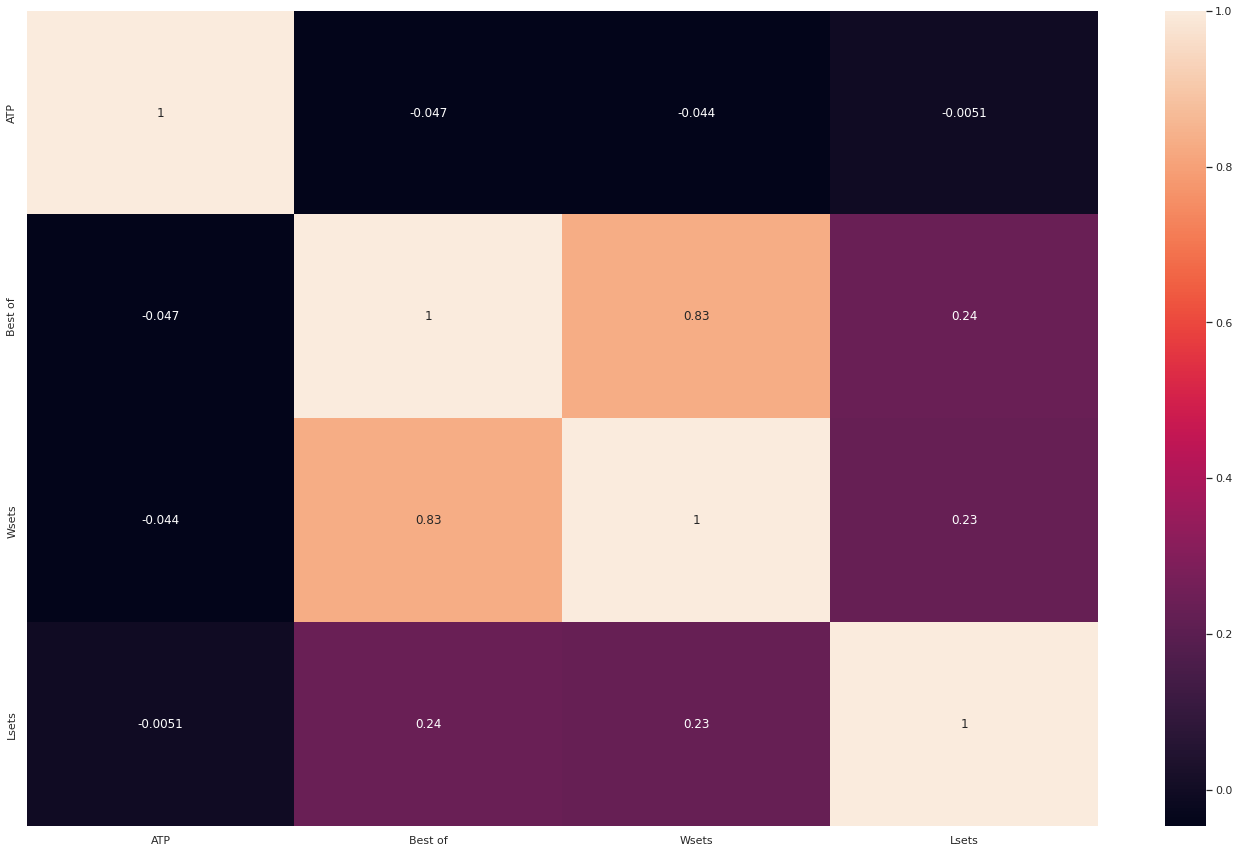

In [ ]:
# find feature correlations
corr_tbl = df.corr()

sns.set(rc={'figure.figsize':(24,15)})
sns.heatmap(corr_tbl, annot=True)

## Data Preprocessing

In [ ]:
# remove correlated columns automatically
corr_df = df.corr()

# get all items above 0.5 correlation and drop them from dataframe 
try: 
  df.drop(['score','tourney_name','winner_name',
                      'loser_name','minutes', 'l_1stIn', 'l_1stWon', 'l_2ndWon','l_ace', 'l_svpt',
                      'l_SvGms','l_bpFaced','l_df', 'l_bpSaved',  'w_1stIn', 'w_1stWon','w_2ndWon', 'w_SvGms',
                      'w_ace', 'w_svpt','w_bpFaced', 'w_bpSaved','w_df'], axis=1, inplace=True)
except KeyError: 
  pass
  
df.info()

<ipython-input-362-3a2fb4903ef4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 59081 entries, 0 to 2631
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         59081 non-null  int64         
 1   Location    59081 non-null  object        
 2   Tournament  59081 non-null  object        
 3   Date        59081 non-null  datetime64[ns]
 4   Series      59081 non-null  object        
 5   Court       59081 non-null  object        
 6   Round       59081 non-null  object        
 7   Best of     59066 non-null  float64       
 8   Winner      59081 non-null  object        
 9   Loser       59081 non-null  object        
 10  Surface     59081 non-null  object        
 11  WRank       59061 non-null  object        
 12  LRank       58979 non-null  object        
 13  Wsets       59080 non-null  float64       
 14  Lsets       59080 non-null  float64       
 15  Comment     59081 non-null  object        
dtypes: datetime64[ns](1), f

In [ ]:
# check nan values
df.isnull().sum()
length = df.shape[0]
nan_prev_threshold: float = 85

null_df = df.isnull().sum()
for col in df.columns:
  null_df[f'{col}_percent'] = (null_df[col]/length)*100
null_df.drop(df.columns, inplace=True)

null_df_refined = pd.DataFrame(columns=['feature', 'nan_prevalence'])
null_df_refined['feature'] = null_df.index
null_df_refined['nan_prevalence'] = null_df.values
null_df_refined = null_df_refined[null_df_refined['nan_prevalence'] < nan_prev_threshold]
null_df_refined.reset_index(inplace=True, drop=True)
features: list = list(null_df_refined['feature'])
features = [col.replace('_percent', '') for col in features]

In [ ]:
df = df[features]
df.shape

(59081, 16)

## Feature Engineering

## Run Once

In [ ]:
try: 
  df.drop(['Date', 'Comment'], inplace=True, axis=1)
except KeyError: 
  pass

NameError: ignored

In [ ]:
# remove nans from sets
df = df[~df['Wsets'].isna()]
df = df[~df['Lsets'].isna()]

NameError: ignored

In [ ]:
df = df[df['Wsets'] != 'NR']
df = df[df['Lsets'] != 'NR']
df = df[df['LRank'] != 'NR']
df = df[df['WRank'] != 'NR']

In [ ]:
df['target_w'] = df['Wsets']
df['target_l'] = df['Lsets']

## Variable Encoding

In [ ]:
# encoding for tournament
tourn_encoder = LabelEncoder()
df['Tournament'] = tourn_encoder.fit_transform(df['Tournament'].astype(str))

# encoder for location
loc_encoder = LabelEncoder()
df['Location'] = loc_encoder.fit_transform(df['Location'].astype(str))

# series encoder
ser_encoder = LabelEncoder()
df['Series'] = ser_encoder.fit_transform(df['Series'].astype(str))

# court encoder
court_encoder = LabelEncoder()
df['Court'] = court_encoder.fit_transform(df['Court'].astype(str))

# round encoder
round_encoder = LabelEncoder()
df['Round'] = round_encoder.fit_transform(df['Round'].astype(str))

# surface encoder
surf_encoder = LabelEncoder()
df['Surface'] = surf_encoder.fit_transform(df['Surface'].astype(str))

# winner and loser encoder
winner_encoder = LabelEncoder()
df['Winner'] = winner_encoder.fit_transform(df['Winner'].astype(str))
loser_encoder = LabelEncoder()
df['Loser'] = loser_encoder.fit_transform(df['Loser'].astype(str))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59054 entries, 0 to 2631
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         59054 non-null  int64  
 1   Location    59054 non-null  int64  
 2   Tournament  59054 non-null  int64  
 3   Series      59054 non-null  int64  
 4   Court       59054 non-null  int64  
 5   Round       59054 non-null  int64  
 6   Best of     59039 non-null  float64
 7   Winner      59054 non-null  int64  
 8   Loser       59054 non-null  int64  
 9   Surface     59054 non-null  int64  
 10  WRank       59034 non-null  object 
 11  LRank       58952 non-null  object 
 12  Wsets       59054 non-null  float64
 13  Lsets       59054 non-null  float64
 14  target_w    59054 non-null  float64
 15  target_l    59054 non-null  float64
dtypes: float64(5), int64(9), object(2)
memory usage: 7.7+ MB


In [ ]:
# imputer handling nan values
df_imputed = pd.DataFrame(SimpleImputer(strategy='most_frequent').fit_transform(df))
df_imputed.columns = df.columns
df_imputed.index = df.index
df = df_imputed.copy()  
df['target_w'] = df['target_w'].astype(int)
df['target_l'] = df['target_l'].astype(int)

## ESPN Data

In [ ]:
from requests import get
from pprint import pprint 
from tqdm import tqdm 
import pickle
import numpy as np
from time import sleep

In [ ]:
# get ids of each team for fetching games later on 
team_ids: list = []
team_url: str = 'https://site.api.espn.com/apis/site/v2/sports/football/nfl/teams'
data = get(team_url).json()
teams = data['sports'][0]['leagues'][0]['teams']
for team in teams: 
  team_ids.append(team['team']['id'])

In [ ]:
# fetch the games for each year by team id
years: list = [2008]

game_ids: list = []

def split_game_id(ref: str): 
  """split the game id out of total url string"""
  game_id_url: str = ref['$ref']
  pre_game_id = game_id_url.split('?')[0]
  game_id = str(pre_game_id.split('events/')[1])
  return game_id

# loop through years
for year in tqdm(years): 
  for team_id in team_ids: 
    #print(team_id)
    game_base_url: str = f'https://sports.core.api.espn.com/v2/sports/football/leagues/nfl/seasons/{year}/teams/{team_id}/events'
    #print(game_base_url)
    game_data = get(game_base_url).json()['items']
    for ref in game_data: 
      game_id = split_game_id(ref)
      game_ids.append(game_id)
len(set(game_ids))

  0%|          | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
# save game ids to pickled file
with open('NFL_Game_ID', 'wb') as fp:
    pickle.dump(game_ids, fp)

NameError: ignored

In [ ]:
def team_scores(data: dict, team_id: str, homeAway: str): 
  """get team standings by team ID"""

  score = np.nan
  week = np.nan

  for competition in data['header']['competitions']: 
    try: 
      for competitor in competition['competitors']: 
        try: 
          if competitor['id'] == team_id and competitor['homeAway'] == homeAway: 
            score = competitor['score']
            week = data['header']['week']
        except (KeyError, IndexError): 
          continue
    except (KeyError, IndexError): 
      continue

  return score, week

def game_stats(data, team_id: str): 
  """get game stats per team id"""

  # init variables
  total_offense, total_yards, yards_play, total_drives, net_pass_yards, inter, rush_yards = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan 
  for team in data['boxscore']['teams']: 
    try: 
      #pprint(team['team'])
      if team['team']['id'] == team_id: 
        # total offense
        try: 
          total_offense = [i for i in team['statistics'] if i['name'] == 'totalOffensivePlays'][0]['displayValue']
        except (KeyError, IndexError): 
          total_offense = np.nan 

        # total yards
        try: 
          total_yards = [i for i in team['statistics'] if i['name'] == 'totalYards'][0]['displayValue']
        except (KeyError, IndexError): 
          total_yards = np.nan 
        
        # yards / play
        try: 
          yards_play = [i for i in team['statistics'] if i['name'] == 'yardsPerPlay'][0]['displayValue']
        except (KeyError, IndexError): 
          yards_play = np.nan 
        
        # total drives
        try: 
          total_drives = [i for i in team['statistics'] if i['name'] == 'totalDrives'][0]['displayValue']
        except (KeyError, IndexError): 
          total_drives = np.nan 

        # net passing yards
        try: 
          net_pass_yards = [i for i in team['statistics'] if i['name'] == 'netPassingYards'][0]['displayValue']
        except (KeyError, IndexError): 
          net_pass_yards = np.nan 
        
        # interceptions
        try: 
          inter = [i for i in team['statistics'] if i['name'] == 'interceptions'][0]['displayValue']
        except (KeyError, IndexError): 
          inter = np.nan 
      
        # rushing yards
        try: 
          rush_yards = [i for i in team['statistics'] if i['name'] == 'rushingYards'][0]['displayValue']
        except (KeyError, IndexError): 
          rush_yards = np.nan
    except (KeyError, IndexError): 
      continue

  return [total_offense, total_yards, yards_play, total_drives, net_pass_yards, inter, rush_yards]

def game_info(game_id: str): 
  """fetch game stats"""

  # wait one second for request to avoid overloading 
  sleep(1)

  # create url
  url: str = f'https://site.api.espn.com/apis/site/v2/sports/football/nfl/summary?event={game_id}'
  data = get(url).json()
  
  # find teams playing
  try: 
    team_1 = data['boxscore']['teams'][0]['team']['id']
    team_2 = data['boxscore']['teams'][1]['team']['id']
  except (KeyError, IndexError): 
    sleep(10)
    url: str = f'https://site.api.espn.com/apis/site/v2/sports/football/nfl/summary?event={game_id}'
    data = get(url).json()
    try: 
      team_1 = data['boxscore']['teams'][0]['team']['id']
      team_2 = data['boxscore']['teams'][1]['team']['id']
    except (KeyError, IndexError): 
      print(game_id)
  
  # find home and away teams
  try: 
    competitions = data['header']['competitions']
  except (KeyError, IndexError): 
    pprint(data)
    print(game_id)

  for competition in competitions: 
    try: 
      for competitor in competition['competitors']: 
        if competitor['id'] == team_1 and competitor['homeAway'] == 'home': 
          team_h = team_1
          team_a = team_2
        else: 
          team_a = team_1
          team_h = team_2
    except (KeyError, IndexError): 
      continue 
  
  # get the score and week
  team_a_score, week = team_scores(data, team_a, 'away')
  team_h_score, week = team_scores(data, team_h, 'home')
  
  # stadium 
  try: 
    stadium = data['gameInfo']['venue']['id']
  except (KeyError, IndexError): 
    stadium = np.nan
  
  # surface
  try: 
    surface = 1 if data['gameInfo']['venue']['grass'] else 0
  except (KeyError, IndexError): 
    surface = np.nan
  
  # in-game stats
  in_game_stats_a = game_stats(data, team_a)
  in_game_stats_h = game_stats(data, team_h)
  
  total_info: list = []
  total_info.extend([team_a, team_h, team_a_score, team_h_score, week, stadium, surface])
  total_info.extend(in_game_stats_a)
  total_info.extend(in_game_stats_h)
  total_info.append(game_id)
  return total_info

container: list = []
for game_id in tqdm(set(game_ids)):
  container.append(game_info(game_id))

features: list = ['away_team', 'home_team', 'away_score', 'home_score', 'week', 'stadium', 'surface', 
                  'away_total_offense', 'away_total_yards', 'away_yard_play', 'away_total_drives', 'away_net_passs_yards', 
                  'away_inter', 'away_rush_yards', 'home_total_offense', 'home_total_yards', 'home_yard_play', 'home_total_drives', 
                  'home_net_passs_yards', 'home_inter', 'home_rush_yards', 'game_id']
df = pd.DataFrame(container, columns=features)
df.to_csv('NFL2022.csv')

## Import NFL Data

In [ ]:
def run(year): 
  df = nfl.import_pbp_data([year])
  df.dropna(subset=['away_score', 'home_score'], inplace=True)

  features: list = ['home_team', 'away_team', 'weather', 'surface', 'stadium', 
                  'week', 'home_wp', 'away_wp', 'location', 'total', 'away_score', 'home_score', 
                  'home_coach', 'away_coach', 'game_id']
  refined_df = pd.DataFrame([], columns=features)
  for game_id in tqdm(df['game_id'].unique()): 
    temp_df = df[df['game_id'] == game_id][features].tail(1)
    refined_df = pd.concat([refined_df, temp_df])
  df = refined_df
  df.reset_index(inplace=True, drop=True)

  print(f"Target Shape: {df.shape}")

  features = list(df.columns)
  features.extend(['W', 'L', 'T', 'PA', 'PF'])
  new_df = pd.DataFrame([], columns=features)
  seen_games: list = []

  for team_id in tqdm(set(teams)): 
    sub_df = df[(df['away_team'] == team_id) | (df['home_team'] == team_id)]
    sub_df.sort_values(by=['week'], inplace=True)
    sub_df.reset_index(inplace=True, drop=True)

    for idx, row in sub_df.iterrows(): 
      prev_df = sub_df.iloc[0:idx, :]

      # count wins 
      wins_home_a = prev_df[prev_df['home_team'] == team_id][prev_df['home_score'] > prev_df['away_score']].shape[0]
      wins_home_b = prev_df[prev_df['away_team'] == team_id][prev_df['away_score'] > prev_df['home_score']].shape[0]
      W = wins_home_a + wins_home_b

      # PCT
      try: 
        PCT = W/prev_df.shape[0]
      except ZeroDivisionError: 
        PCT = np.nan 

      # Losses
      loss_home_a = prev_df[prev_df['home_team'] == team_id][prev_df['home_score'] < prev_df['away_score']].shape[0]
      loss_home_b = prev_df[prev_df['away_team'] == team_id][prev_df['away_score'] > prev_df['home_score']].shape[0]
      L = loss_home_a + loss_home_b

      # Ties
      T = prev_df[prev_df['home_score'] == prev_df['away_score']].shape[0]

      # Points for & against
      PF = prev_df[prev_df['away_team'] == team_id]['away_score'].sum() + prev_df[prev_df['home_team'] == team_id]['home_score'].sum()
      PA = prev_df[prev_df['away_team'] == team_id]['home_score'].sum() + prev_df[prev_df['home_team'] == team_id]['away_score'].sum()

      # insert computed variables
      sub_df.at[idx, 'W'] = W
      sub_df.at[idx, 'L'] = L
      sub_df.at[idx, 'T'] = T
      sub_df.at[idx, 'PA'] = PA
      sub_df.at[idx, 'PF'] = PF
      sub_df.at[idx, 'PCT'] = PCT
      sub_df.at[idx, '%ref'] = team_id

    # stack dataframes
    new_df = pd.concat([new_df, sub_df])

  new_features: list = list(new_df.iloc[:, :22].columns)
  new_features.extend(['W_A', 'L_A', 'T_A', 'PA_A', 'PF_A', 'PCT_A', 'W_H', 'L_H', 'T_H', 'PA_H', 'PF_H', 'PCT_H'])
  container: list = []

  for game_id in tqdm(list(new_df['game_id'].unique())): 
    # get the smaller dataframe for each game to remove duplicates
    sub_df = new_df[new_df['game_id'] == game_id]
    sub_df.reset_index(inplace=True, drop=True)

    W_A, W_H, T_A, T_H, L_A, L_H, PA_A, PA_H, PF_A, PF_H, PCT_A, PCT_H = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # stack statistics by team
    for idx, row in sub_df.iterrows():
      team_reference: int = row['%ref']
      if row['away_team'] == team_reference: 
        W_A = row['W']
        T_A = row['T']
        L_A = row['L']
        PA_A = row['PA']
        PF_A = row['PF']
        PCT_A = row['PCT']
      else: 
        W_H = row['W']
        T_H = row['T']
        L_H = row['L']
        PA_H = row['PA']
        PF_H = row['PF']
        PCT_H = row['PCT']

    sub_df['W_A'] = [W_A for _ in range(sub_df.shape[0])]
    sub_df['W_H'] = [W_H for _ in range(sub_df.shape[0])]
    sub_df['L_A'] = [L_A for _ in range(sub_df.shape[0])]
    sub_df['L_H'] = [L_H for _ in range(sub_df.shape[0])]
    sub_df['T_A'] = [T_A for _ in range(sub_df.shape[0])]
    sub_df['T_H'] = [T_H for _ in range(sub_df.shape[0])]
    sub_df['PA_A'] = [PA_A for _ in range(sub_df.shape[0])]
    sub_df['PA_H'] = [PA_H for _ in range(sub_df.shape[0])]
    sub_df['PF_A'] = [PF_A for _ in range(sub_df.shape[0])]
    sub_df['PF_H'] = [PF_H for _ in range(sub_df.shape[0])]
    sub_df['PCT_A'] = [PF_H for _ in range(sub_df.shape[0])]  
    sub_df['PCT_H'] = [PF_H for _ in range(sub_df.shape[0])]

    # remove team reference id
    sub_df.drop('%ref', inplace=True, axis=1)
    new_features = sub_df.columns
    container.append(sub_df.iloc[0].values)

  final_df = pd.DataFrame(container, columns=new_features)
  return final_df

df = pd.DataFrame()
for year in range(1999, 2023): 
  run(year).to_csv(f'NFL{year}.csv')

1999 done.
Downcasting floats.


100%|██████████| 258/258 [00:01<00:00, 216.73it/s]


Target Shape: (258, 15)


NameError: ignored

In [ ]:
# combine files into one singular dataframe
start_path: str = '/content/drive/MyDrive/BetAIData/NFL/NFL1999.csv'
start_df = pd.read_csv(start_path).drop('Unnamed: 0', axis=1)
final_df = pd.DataFrame([], columns=start_df.columns)

for i in range(1999, 2023): 
  temp_df = pd.read_csv(f'/content/drive/MyDrive/BetAIData/NFL/NFL{i}.csv').drop('Unnamed: 0', axis=1)
  final_df = pd.concat([final_df, temp_df])
final_df

## Updated Game-by-Game Model

In [ ]:
#df[['home_team', 'away_team', 'total_home_score', 'total_away_score']][:50]
from tqdm import tqdm 
features: list = ['home_team', 'away_team', 'surface', 'stadium', 
                  'week', 'home_wp', 'away_wp', 'location', 'total', 'away_score', 'home_score', 
                  'home_coach', 'away_coach', 'W_A', 'L_A', 'T_A', 'PA_A', 'PF_A', 'W_H', 'L_H', 'T_H', 'PA_H', 'PF_H']

In [ ]:
df = final_df[features]

In [ ]:
from sklearn.preprocessing import LabelEncoder

team_arr: list = []
team_arr.extend(list(df['away_team']))
team_arr.extend(list(df['home_team']))

home_enc = LabelEncoder()
home_enc.fit(team_arr)
df['away_team'] = home_enc.transform(df['away_team'])
df['home_team'] = home_enc.transform(df['home_team'])

df['total_score'] = df['home_score'] + df['away_score']

In [ ]:
coach_arr: list = []
coach_arr.extend(list(df['away_coach']))
coach_arr.extend(list(df['home_coach']))

coach_enc = LabelEncoder()
coach_enc.fit(coach_arr)
df['away_coach'] = coach_enc.transform(df['away_coach'])
df['home_coach'] = coach_enc.transform(df['home_coach'])

stad_enc = LabelEncoder()
df['stadium'] = stad_enc.fit_transform(df['stadium'])

In [ ]:
df['Target'] = df["total_score"] > 36.5
df['Target'] = df['Target'].astype(int)

In [ ]:
df.drop('surface', axis=1, inplace=True)

In [ ]:
df['total_score'] = df['total_score'].astype(int)
df['week'] = df['week'].astype(int)
df['total'] = df['total'].astype(int)
df['away_score'] = df['away_score'].astype(int)
df['home_score'] = df['home_score'].astype(int)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE, SMOTEN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score

df.dropna(inplace=True)
X = df.drop(['Target', 'away_score', 'home_score', 'total_score', 'total', 'location', 'home_wp', 'away_wp'], axis=1)
y = df[['Target']]

# oversample with SMOTE 
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.1, stratify=y)

model = XGBClassifier()
scores = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
print(scores)
model.fit(X_train.values, y_train.values)
preds = model.predict(X_test.values)
roc_auc_score(preds, y_test)

In [ ]:
import matplotlib.pyplot as plt 
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

In [ ]:
probs_pred = model.predict_proba(X_test.values)
confidence = 0.72

correct, incorrect, skipped = 0, 0, 0

for arr_prob, actual in zip(probs_pred, y_test.values): 
  prob = arr_prob[np.argmax(arr_prob)]
  pred = np.argmax(arr_prob)

  if prob > confidence: 
    if pred == actual[0]: 
      correct += 1
    else: 
      incorrect += 1
  else: 
    skipped += 1

print(correct / (incorrect + correct))
print(skipped / len(y_test))

In [ ]:
X.columns

## Run

In [ ]:
from pprint import pprint
from IPython.display import clear_output 

# create prompt for selecting players
coach = list(df['away_coach'].unique())
coach2 = list(df['home_coach'].unique())
coach.extend(coach2)
fullcoaches = {i: coach_enc.inverse_transform([i])[0] for i in set(coach)}
fullcoaches = sorted(fullcoaches.items(), key=lambda x:x[1])

# stadiums 
stadiums = {i: stad_enc.inverse_transform([i])[0] for i in X['stadium'].unique()}
stadiums[153] = 'None'
stadiums = sorted(stadiums.items(), key=lambda x:x[1])

teams = list(df['away_team'].unique())
teams2 = list(df['home_team'].unique())
teams.extend(teams2)
fullteams = {i: home_enc.inverse_transform([i])[0] for i in set(teams)}
fullteams = sorted(fullteams.items(), key=lambda x:x[1])

### ------PROMPT------

# coaches
pprint(fullcoaches)
C1 = int(input("Coach 1: "))
C2 = int(input("Coach 2: "))
clear_output()

# stadium 
pprint(stadiums)
stadium_fet = int(input("Stadium: "))
clear_output()

# week
week_fet = int(input("Week: "))
clear_output()

# players
pprint(fullteams)
T1 = int(input("Team 1: "))
T2 = int(input("Team 2: "))
clear_output()

# team stats
W_A_fet = int(input("Wins Away: "))
L_A_fet = int(input("Losses Away: "))
T_A_fet = int(input("Ties Away: "))
PF_A_fet = int(input("PF Away: "))
PA_A_fet = int(input("PA Away: "))

W_H_fet = int(input("Wins Home: "))
L_H_fet = int(input("Losses Home: "))
T_H_fet = int(input("Ties Away: "))
PF_H_fet = int(input("PF Home: "))
PA_H_fet = int(input("PA Home: "))

# predict and return result
X_pred = [T1, T2, stadium_fet, week_fet, C1, C2, W_A_fet, L_A_fet, T_A_fet, PA_A_fet, PF_A_fet, 
          W_H_fet, L_H_fet, T_H_fet, PA_H_fet, PF_H_fet]
y_pred = model.predict_proba([X_pred])
if np.argmax(y_pred) == 1: 
  print('Over: ', str(np.round(100*y_pred[0][np.argmax(y_pred)], 2)) + '%', f'Minimum Confidence: {72}.00%')
else: 
  print('Under: ', str(np.round(100*y_pred[0][np.argmax(y_pred)], 2)) + '%', f'Minimum Confidence: {72}.00%')